# スパース回帰
ガウスカーネルモデルに対して，交互方向乗数法によるスパース回帰を実行する  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#曲線に沿ってノイズを含んだサンプルを生成
def generate_sample(xmin, xmax, sample_size):
    np.random.seed(0)
    x = np.linspace(start=xmin, stop=xmax, num=sample_size)
    pix = np.pi * x
    target = np.sin(pix) / pix + 0.1 * x
    noise = 0.05 * np.random.normal(loc=0., scale=1., size=sample_size)
    return x, target + noise

In [3]:
#ガウスカーネルを生成
def calc_design_matrix(x, c, h):
    return np.exp(-(x[None] - c[:, None]) ** 2 / (2 * h ** 2))

In [4]:
#交互方向乗数法によって最適なthetaを求める関数
def lsm_admm(l, h, x_train, y_train):
    k = calc_design_matrix(x_train, x_train, h)
    theta = np.random.rand(len(k))
    theta_old = np.zeros(len(k))
    z = theta
    u = np.random.rand(len(k))
    
    e = 1e-5 #更新後の変化量が小さくなったら打ち切る
    while np.linalg.norm(theta - theta_old) > e:
        theta_old = theta
        theta = np.linalg.solve(k.T.dot(k) + np.identity(len(k)), k.T.dot(y_train[:, None]).reshape(-1,) + z - u)
        z = np.maximum(0, theta + u - l*np.ones(len(k)) ) - np.maximum(0, -theta - u - l*np.ones(len(k)) )
        u = u + theta - z
        theta = z
    return theta

## Main (交互方向乗数法)
train data 50個　test data 20個　同じ分布に従うサンプルを生成  
パラメータh, lは手動で調整  
スパース性を確認するため，最適化されたthetaと，thetaの成分のうち0であるものの割合 (sparse rate) を表示  
またtest data のlossも表示  
プロットにおいて緑点はtrain_data, 赤点はtest_data, 青線は予測した曲線  

theta : 
 [-0.12454482  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.153711   -0.15436382  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.12834748  0.91920799  0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.06089532
 -0.02636514  0.          0.          0.          0.          0.
  0.          0.          0.          0.19911137  0.16022963  0.
  0.          0.        ]
sparse rate : 0.82
test loss : 0.22946655476858313


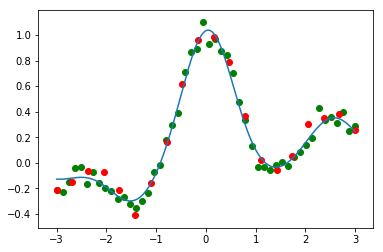

In [5]:
xmin, xmax = -3, 3
x_train, y_train = generate_sample(xmin=xmin, xmax=xmax, sample_size=50)
x_test, y_test = generate_sample(xmin=xmin, xmax=xmax, sample_size=20)

h = 0.5
l = 0.1

#train
theta = lsm_admm(l, h, x_train, y_train)
print('theta : \n', theta)
print('sparse rate :', np.mean(theta==0))

#test
k_test = calc_design_matrix(x_train, x_test, h)
pred_test = k_test.dot(theta).reshape(-1,)
loss = np.dot((pred_test - y_test),(pred_test - y_test))/2 + l*np.linalg.norm(theta, ord=1)
print('test loss :', loss)

# create data to visualize the prediction
x_plot = np.linspace(start=xmin, stop=xmax, num=5000)
k_plot = calc_design_matrix(x_train, x_plot, h)
prediction = k_plot.dot(theta)

# visualization
plt.clf()
plt.scatter(x_train, y_train, c='green', marker='o')
plt.scatter(x_test, y_test, c='red', marker='o')
plt.plot(x_plot, prediction)
plt.savefig('lsm_admm.png')

うまく値を選ぶと，例えば h = 0.5, l = 0.1 のときsparse rate = 0.82 と高いスパース性のある解が得られた．またlossの値はL2ノルムを使った場合と同程度の結果が得られ，精度が保たれていることがわかる．   
勾配法のためパラメータの値によっては計算時間がかなり長くなった．  
hを大きくすると曲線が緩やかになってスパース性が向上し，逆に小さくするとスパース性が低下した．  
lを変化させても極端な値でない限りスパース性の度合いはあまり変化しなかった．  